<a href="https://colab.research.google.com/drive/10jmbpP0xcbJXsmWvy2yvI4v04Y4v65Tp?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Построение вопросно-ответной системы с использованием RAG

### импорты

In [1]:
from IPython.display import clear_output

In [2]:
! pip install datasets transformers
clear_output()

In [3]:
import torch
from datasets import load_dataset, Dataset, concatenate_datasets
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set(font_scale=0.8)
sns.set_palette('pastel')

import nltk
from nltk.tokenize import sent_tokenize
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from collections import defaultdict
from collections import  Counter

from sklearn.feature_extraction.text import CountVectorizer
import wordcloud
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

import gensim
from gensim.models import Word2Vec
from nltk import FreqDist
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### загрузка датасета

In [4]:
# Download dataset
rag_dataset = load_dataset("neural-bridge/rag-dataset-12000")
# merge train and test
rag_dataset_combined = concatenate_datasets([rag_dataset["train"], rag_dataset["test"]])
# shuffle data
rag_dataset_ready = rag_dataset_combined.shuffle(seed=42)
# to pandas dataset
rag_dataset_ready_df = rag_dataset_ready.to_pandas()
# rag_dataset_ready_df["context"] = rag_dataset_ready_df["context"].apply(lambda data: [data])
rag_dataset_ready = Dataset.from_pandas(rag_dataset_ready_df)

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

(…)-00000-of-00001-9df3a936e1f63191.parquet:   0%|          | 0.00/23.1M [00:00<?, ?B/s]

(…)-00000-of-00001-af2a9f454ad1b8a3.parquet:   0%|          | 0.00/5.79M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2400 [00:00<?, ? examples/s]

In [5]:
# вывод одного сэмпла
rag_dataset_ready[0]

{'context': 'Dr. Philip Mummert\nAssistant Head\nMathematics Department\nPurdue University\nWest Lafayette, Indiana\nResearch\nI\'m interested in discrete dynamical systems (iteration theory) of several complex variables.\nDissertation\nHorseshoes, solenoids, and holomorphic motions for Hénon maps\nAdvisors Dr. Gregery Buzzard and Dr. John Smillie\nI also enjoy learning about complex analysis, real analysis, mathematical physics, discrete math, computer algorithms, and financial mathematics.\nAwards\n2012 Distinguished Lecture in the Taylor University School of Natural and Applied Sciences\nPast undergraduate research projects\nComplex and Symbolic Dynamics, with Sarah Stoops, Anna Durham, and Paije Smith, Fall 2014 and Spring 2015.\nVoronoi Vertex Iteration, with Justin Southworth and Bill Solyst, Summer 2012.\nAustrian Solitaire with Rachel DeMeo and Daniel Kasper, Summer 2010.\nDiscrete Complex Analysis with Joseph Seaborn, Summer 2009.\nEvolution of finite one-dimensional Cellular 

Видны посторонние символы, такие как перевод строки \n

In [ ]:
rag_dataset_ready_df

,context,question,answer
0,Dr. Philip Mummert\nAssistant Head\nMathematic...,What is Dr. Philip Mummert's area of research ...,Dr. Philip Mummert is interested in discrete d...
1,11 Things You Can Do While Working To Have A B...,What are some things you can do at work to hav...,Some things you can do at work to have a bette...
2,"For the last three years, law firm Perkins Coi...",What are some of the key findings from the Fou...,The key findings from the survey include incre...
3,"What the Hell, Eva Mendes?\nAnd what the hell ...",Who took the photos mentioned in the context?,The photos were taken by Steven Meisel.
4,"2756 Greenhill Ln, Lynchburg, VA 24503\n3 beds...",What is the last sold price and date for the p...,"The property at 2756 Greenhill Ln, Lynchburg, ..."
...,...,...,...
11995,Photo Credit: Patrick Kolts for Find. Eat. Dri...,Who is considered one of the most studied coff...,Roaster Trish Rothgeb is considered one of the...
11996,A horrific crash on the Pennsylvania Turnpike ...,What vehicles were involved in the horrific cr...,Multiple vehicles including two commercial tra...
11997,\n16 Comments\n1\nBest Rodriguez Film Yet\nMiK...,What are some of the viewers' opinions about t...,"The viewers' opinions about the movie ""Machete..."
11998,"While most parties aren't this wild, it made m...",What are some tips for conducting oneself at a...,Some tips for conducting oneself at a holiday ...


Имеется 3 колонки и 12000 строк

In [ ]:
rag_dataset_ready_df['question'][0]

"What is Dr. Philip Mummert's area of research interest?"

In [ ]:
rag_dataset_ready_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   12000 non-null  object
 1   question  11997 non-null  object
 2   answer    11997 non-null  object
dtypes: object(3)
memory usage: 281.4+ KB


In [6]:
# пустые значение
rag_dataset_ready_df[rag_dataset_ready_df['question'].isnull()]

,context,question,answer
3005,.\nThe. Give people.\nHome Office. (2002). A g...,None,None
4970,come back ! for Budcome back ! for Bud\nthe st...,None,None
6631,"Flood,\nDefinition of Flood:\n-\nArrive in lar...",None,None


### EDA

In [7]:
df = rag_dataset_ready_df.copy()

df.columns

Index(['context', 'question', 'answer'], dtype='object')

In [8]:
# проверка на полные дубликаты
df[df.duplicated()]

,context,question,answer


In [9]:
# проверка на дубликаты в колонке context
df[df.duplicated(subset=['context'])]

,context,question,answer


In [10]:
# проверка на дубликаты в колонке question

df[df.duplicated(subset=['question'])]

,context,question,answer
2327,Remembering The Dogs of The Titanic\nApril 15t...,What is the main topic discussed in the context?,The main topic discussed in the context is rem...
3281,"Surprisingly, it took me a long time to find t...",What is the context about?,The context is about sorting 2D associative ar...
3546,Explore Concrete Pump Operator careers and fin...,What are some of the job roles mentioned in th...,Some of the job roles mentioned in the context...
4970,come back ! for Budcome back ! for Bud\nthe st...,None,None
5487,The synthetic fragrant compounds based on 2-te...,What is the context about?,The context is about synthetic fragrant compou...
5714,"""they are both comparatively late age, on n'a ...",What is the context about?,The context is a collection of various sentenc...
5763,Description\nIf I eat flour I prefer to eat ry...,What are the ingredients needed for the recipe...,The ingredients needed for the recipe are Rye ...
6136,Virginia Asthma And Allergy\nWay alteration do...,What is the main topic discussed in the context?,Virginia Asthma And Allergy
6631,"Flood,\nDefinition of Flood:\n-\nArrive in lar...",None,None
6909,Background – Nectar Mattress Review – Is This ...,What are some of the features that set the Nec...,Some of the features that set the Nectar mattr...


Видим, что есть повторяющиеся вопросы, но это скорее вопросы общего характера, могут быть использованы к разным контекстам, не будем считать это аномалией

Также обнаружены несколько строк с None

In [11]:
# проверка на дубликаты в колонке answer

df[df.duplicated(subset=['answer'])]

,context,question,answer
4970,come back ! for Budcome back ! for Bud\nthe st...,None,None
6631,"Flood,\nDefinition of Flood:\n-\nArrive in lar...",None,None


In [12]:
# удаление строк с пустыми значениями (None)
df = df.dropna()

In [13]:
df['context'][0]

'Dr. Philip Mummert\nAssistant Head\nMathematics Department\nPurdue University\nWest Lafayette, Indiana\nResearch\nI\'m interested in discrete dynamical systems (iteration theory) of several complex variables.\nDissertation\nHorseshoes, solenoids, and holomorphic motions for Hénon maps\nAdvisors Dr. Gregery Buzzard and Dr. John Smillie\nI also enjoy learning about complex analysis, real analysis, mathematical physics, discrete math, computer algorithms, and financial mathematics.\nAwards\n2012 Distinguished Lecture in the Taylor University School of Natural and Applied Sciences\nPast undergraduate research projects\nComplex and Symbolic Dynamics, with Sarah Stoops, Anna Durham, and Paije Smith, Fall 2014 and Spring 2015.\nVoronoi Vertex Iteration, with Justin Southworth and Bill Solyst, Summer 2012.\nAustrian Solitaire with Rachel DeMeo and Daniel Kasper, Summer 2010.\nDiscrete Complex Analysis with Joseph Seaborn, Summer 2009.\nEvolution of finite one-dimensional Cellular Automata wit

In [14]:
# удаление/замена на пробел знака перевода строки в колонке 'context'
df['context'] = df['context'].apply(lambda x: x.replace('\n', ' '))
df

,context,question,answer
0,Dr. Philip Mummert Assistant Head Mathematics ...,What is Dr. Philip Mummert's area of research ...,Dr. Philip Mummert is interested in discrete d...
1,11 Things You Can Do While Working To Have A B...,What are some things you can do at work to hav...,Some things you can do at work to have a bette...
2,"For the last three years, law firm Perkins Coi...",What are some of the key findings from the Fou...,The key findings from the survey include incre...
3,"What the Hell, Eva Mendes? And what the hell t...",Who took the photos mentioned in the context?,The photos were taken by Steven Meisel.
4,"2756 Greenhill Ln, Lynchburg, VA 24503 3 beds3...",What is the last sold price and date for the p...,"The property at 2756 Greenhill Ln, Lynchburg, ..."
...,...,...,...
11995,Photo Credit: Patrick Kolts for Find. Eat. Dri...,Who is considered one of the most studied coff...,Roaster Trish Rothgeb is considered one of the...
11996,A horrific crash on the Pennsylvania Turnpike ...,What vehicles were involved in the horrific cr...,Multiple vehicles including two commercial tra...
11997,16 Comments 1 Best Rodriguez Film Yet MiKe M?...,What are some of the viewers' opinions about t...,"The viewers' opinions about the movie ""Machete..."
11998,"While most parties aren't this wild, it made m...",What are some tips for conducting oneself at a...,Some tips for conducting oneself at a holiday ...


#### Length of texts (histogram)


* sentence length analysis
* average word length analysis

In [15]:
# посмотрим на длины текстов по символам и по словам

# context
df['length__context_word'] = df.context.astype('str').apply(lambda text : len(text.split()))
df['length_contex_symbol'] = df.context.astype('str').apply(len)

# question
df['length__question_word'] = df.question.astype('str').apply(lambda text : len(text.split()))
df['length_question_symbol'] = df.question.astype('str').apply(len)

# answer
df['length__answer_word'] = df.answer.astype('str').apply(lambda text : len(text.split()))
df['length_answer_symbol'] = df.answer.astype('str').apply(len)

df.head(3)

,context,question,answer,length__context_word,length_contex_symbol,length__question_word,length_question_symbol,length__answer_word,length_answer_symbol
0,Dr. Philip Mummert Assistant Head Mathematics ...,What is Dr. Philip Mummert's area of research ...,Dr. Philip Mummert is interested in discrete d...,223,1649,9,55,15,111
1,11 Things You Can Do While Working To Have A B...,What are some things you can do at work to hav...,Some things you can do at work to have a bette...,1104,6140,21,105,95,532
2,"For the last three years, law firm Perkins Coi...",What are some of the key findings from the Fou...,The key findings from the survey include incre...,990,6370,23,130,132,884


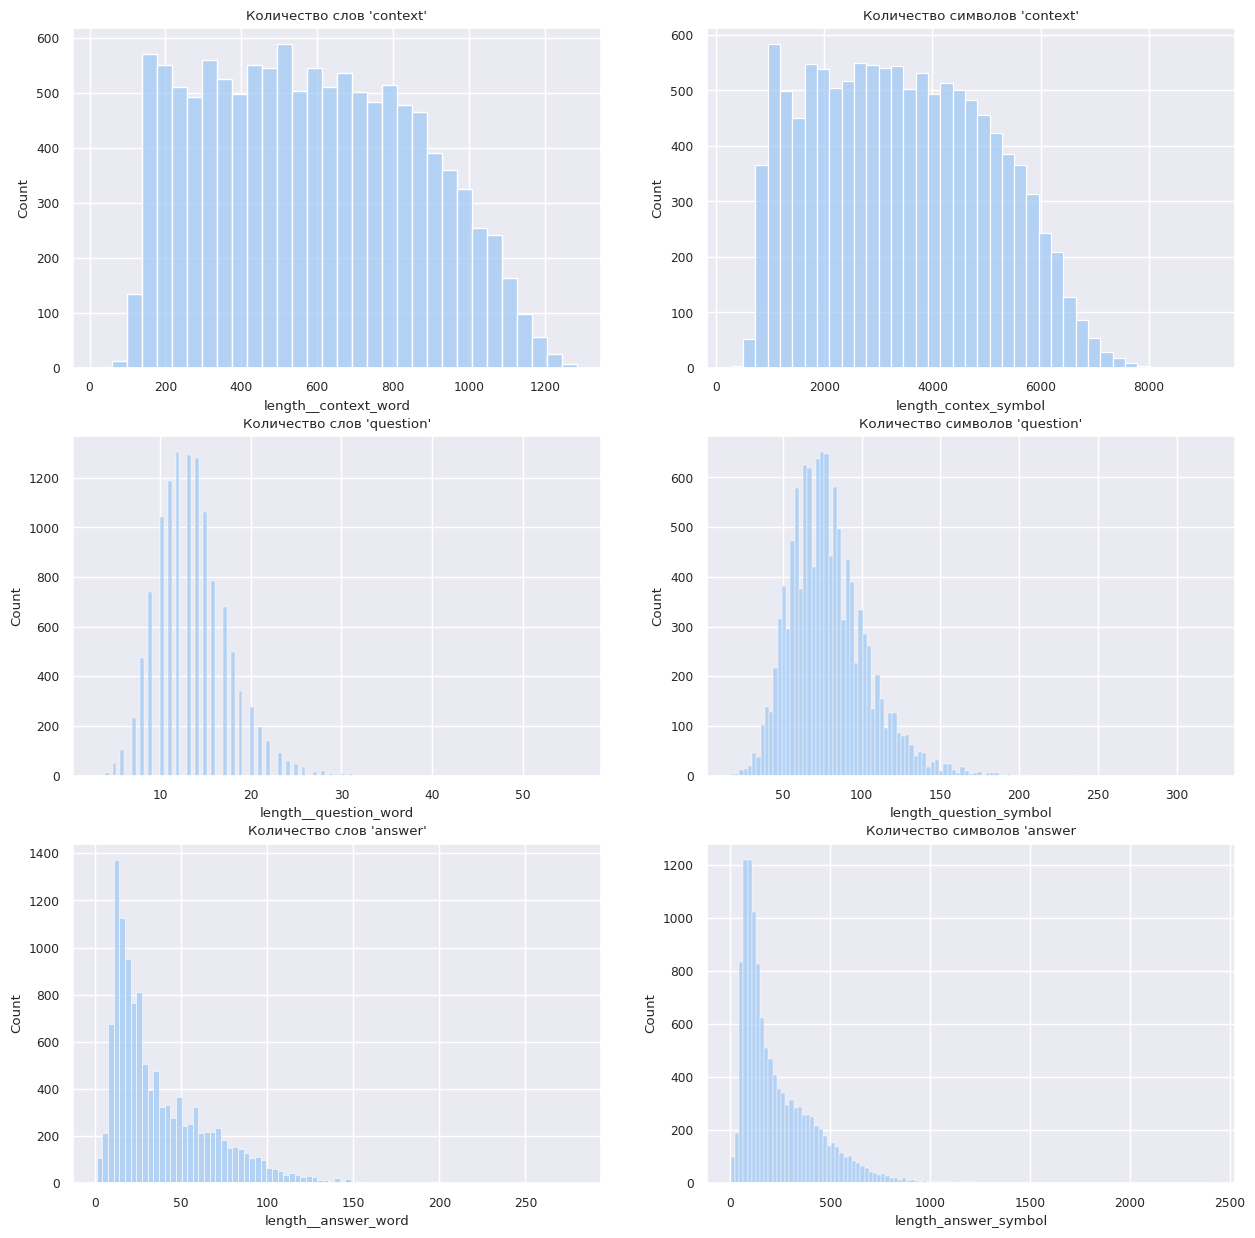

In [17]:
plt.figure(figsize = (15, 15))

plt.subplot(3, 2, 1)
sns.histplot(df["length__context_word"]).set_title("Количество слов 'context'")

plt.subplot(3, 2, 2)
sns.histplot(df["length_contex_symbol"]).set_title("Количество символов 'context'")

plt.subplot(3, 2, 3)
sns.histplot(df["length__question_word"]).set_title("Количество слов 'question'")

plt.subplot(3, 2, 4)
sns.histplot(df["length_question_symbol"]).set_title("Количество символов 'question'");

plt.subplot(3, 2, 5)
sns.histplot(df["length__answer_word"]).set_title("Количество слов 'answer'")

plt.subplot(3, 2, 6)
sns.histplot(df["length_answer_symbol"]).set_title("Количество символов 'answer");

In [16]:
df.describe(include='int64').T

,count,mean,std,min,25%,50%,75%,max
length__context_word,11997.0,581.932400,275.201171,19.0,347.0,570.0,800.0,1285.0
length_contex_symbol,11997.0,3437.894390,1612.886261,271.0,2080.0,3364.0,4698.0,9156.0
length__question_word,11997.0,13.563057,3.961316,3.0,11.0,13.0,16.0,56.0
length_question_symbol,11997.0,79.098691,24.846573,17.0,62.0,76.0,93.0,322.0
length__answer_word,11997.0,38.352005,30.098918,1.0,16.0,27.0,54.0,280.0
length_answer_symbol,11997.0,237.182796,189.504162,2.0,97.0,169.0,337.0,2408.0


Выводы:
* Самая объемная по количеству текста - слов и символов колонка context, максимальный текст в этой колонке состоит из 1285 слов, минимальный из 19.
* Привлекли внимание записи в колонке 'answer' длиной в 2 символа и в 1 слово, но после проверки, можно признать, что значение валидное (это ответ в виде двузначной цифры и коротким отрицательным словом)
* Минимальная длина текста 2 символа в колонке  'answer'
* в колонке question тексты от 3 до 56 слов


In [24]:
df.loc[df.length_answer_symbol <= 2]

,context,question,answer,length__context_word,length_contex_symbol,length__question_word,length_question_symbol,length__answer_word,length_answer_symbol
2269,Maria Henry (Nee Hardy) (born 1851) Biography ...,What was Maria Henry's maiden name?,Ne,192,1083,6,35,1,2
9362,Director: – Dailymotion Watch Part 1 Watch Par...,How many servers are mentioned in the context?,14,160,800,8,46,1,2


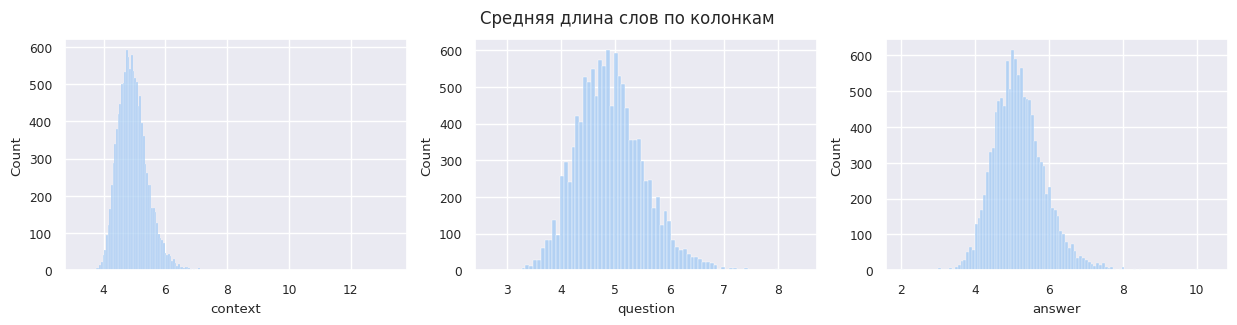

In [18]:
# Средняя длина слова  по колонкам

plt.figure(figsize = (15, 3)).suptitle('Средняя длина слов по колонкам', fontsize=12)

plt.subplot(1, 3, 1)
sns.histplot(df['context'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)));

plt.subplot(1, 3, 2)
sns.histplot(df['question'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)));

plt.subplot(1, 3, 3)
sns.histplot(df['answer'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)));

* Длина слова в 'context'  часще всего равна 5 символам, и редко используются слова меньше, чем из 3-х символов.
* 'question' - есть довольно много слов длиной до 4 символов
* 'answer' - есть довольно много слов длиной до 4 символов, есть слова от 2-х символов

Посмотрим распределение по длинам предложений с использованием nltk.sent_tokenize

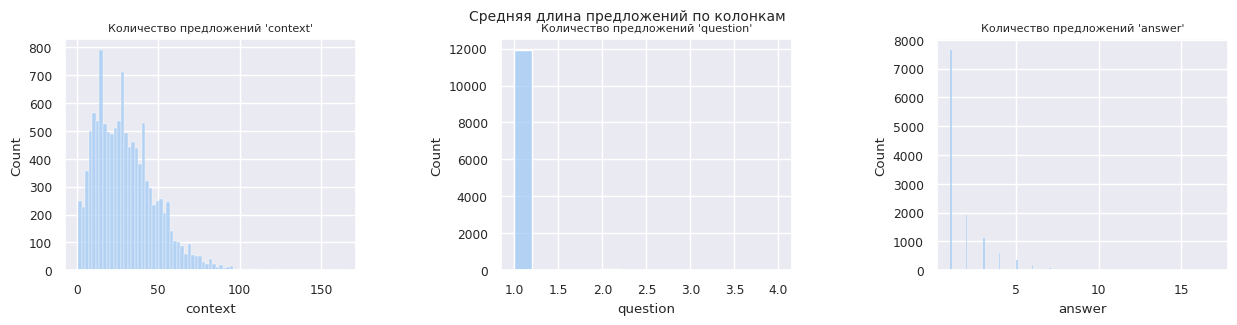

In [25]:
plt.figure(figsize = (15, 3)).suptitle('Средняя длина предложений по колонкам', fontsize=10)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.subplot(1, 3, 1)
sns.histplot(df.context.astype('str').apply(lambda text : len(sent_tokenize(text)))).set_title("Количество предложений 'context'", fontsize=8);

plt.subplot(1, 3, 2)
sns.histplot(df.question.astype('str').apply(lambda text : len(sent_tokenize(text)))).set_title("Количество предложений 'question'", fontsize=8);

plt.subplot(1, 3, 3)
sns.histplot(df.answer.astype('str').apply(lambda text : len(sent_tokenize(text)))).set_title("Количество предложений 'answer'", fontsize=8);

* Видно, что в основном количество предложений в поле 'context' достигает 100, небольшое количество предложений от 100 до 150. Значения довольно условное, так как sent_tokenize токенизирует неидеально.
* Вопросы 'question' в основном из одного предложения
* Ответы 'answer' в большинстве состоят из 1 предложения, есть поля до 10 предложений, но их мало.

#### Frequency


Проанализируем стоп-слова (частотность, количество) в столбце 'context'  (находить стоп-слова будем с помощью nltk.stopwords('english'))

In [26]:
# Зафиксируем список стоп-слов
STOPWORDS = set(nltk.corpus.stopwords.words('english') + ['-', '-', '–','&'])
# функция, токенизирует по словам переданный ей текст в список слов, возвращает корпус токенов
def corpus(text):
    words = text.str.split().values.tolist()
    corpus = [word.lower() for i in words for word in i]
    return corpus

In [27]:
# функция для создания столбчатой диаграммы для 15 наиболее часто встречамых стоп-слов и

def plot_top_words(text, stop = STOPWORDS):
    plt.figure(figsize = (15, 7)).suptitle('Наиболее часто встречающиеся стоп-слова и топ _НЕ_ стоп-слов', fontsize=10)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    # токенизация на слова
    corp = corpus(text)
    # создание словаря с слово : количество вхождений
    dic = defaultdict(int)
    for word in corp:
        if word in stop:
            dic[word.lower()]+=1
        #   сортировка словаря
    top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15]
    z,w=zip(*top)
    plt.subplot(1, 2, 1)
    plt.bar(z,w)

    counter = Counter(corp)
    most = counter.most_common()


    x, y =[], []
    # отбор слов, которых нет в списке стоп-слов
    for word,count in most[:99]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.subplot(1, 2, 2)
    sns.barplot(x = y,y = x, hue=y)

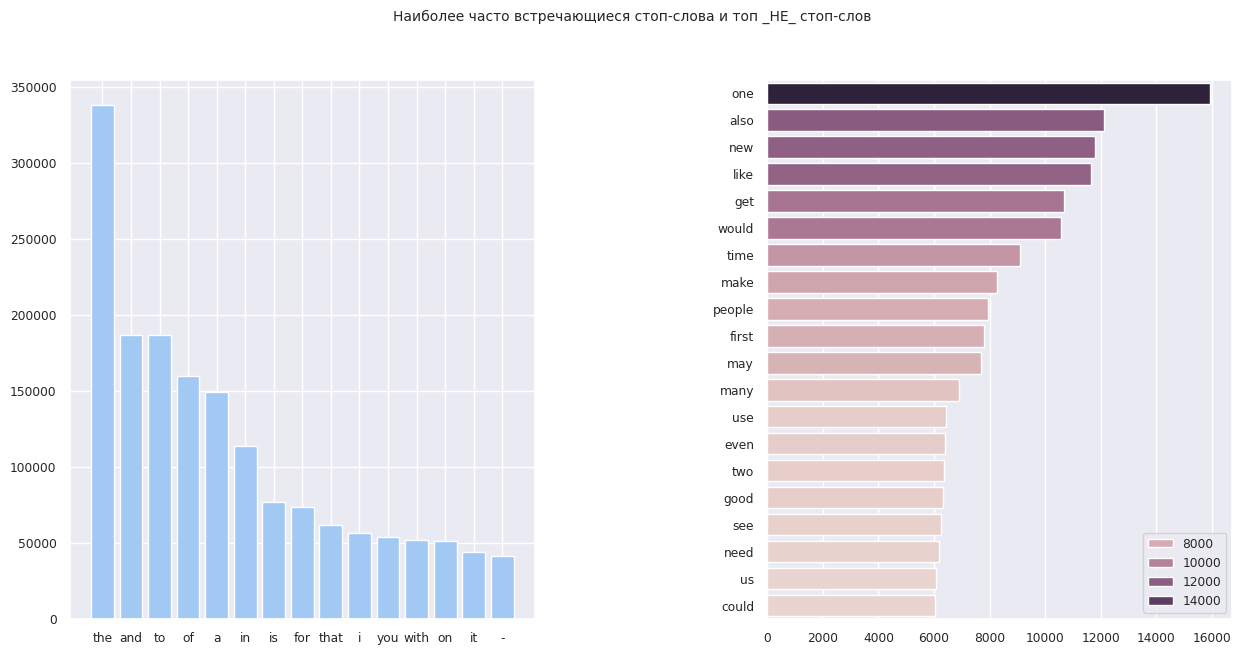

In [28]:
plot_top_words(df['context'])

context:  
наиболее частотные стоп-слова - это артикли, предлоги, тире
наиболее частот НЕ стоп-слова - числительное one, наречие also, прилагательное new, довольно обычный набор слов, свойственный повестованию

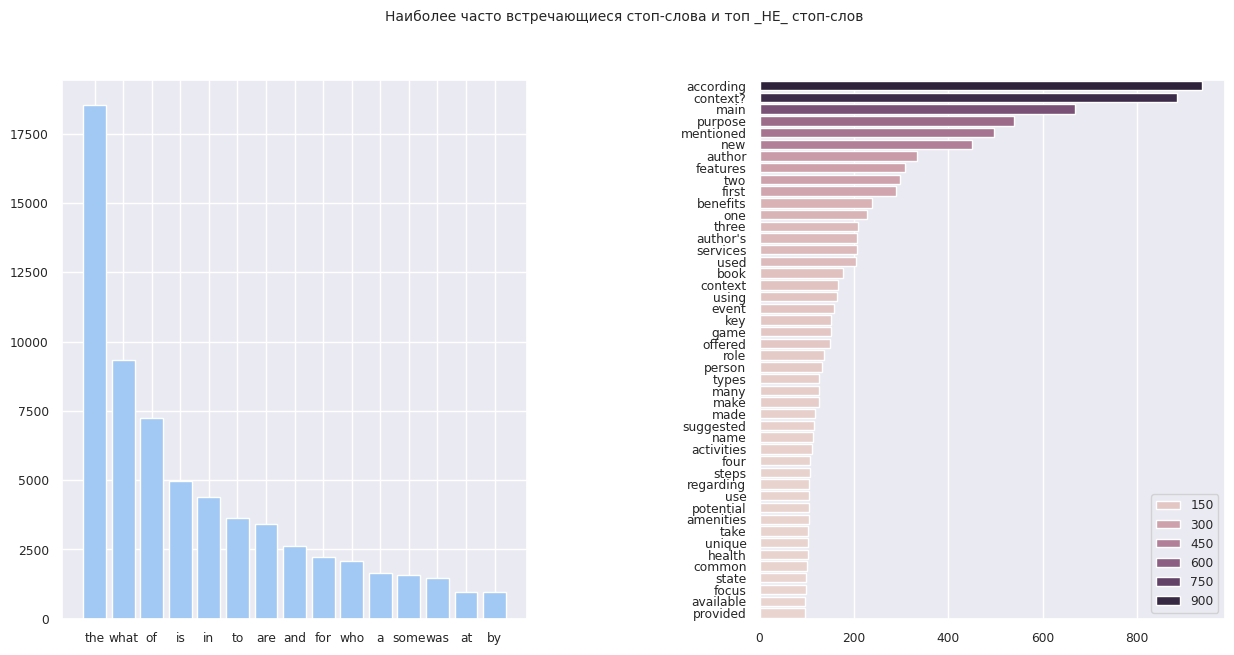

In [ ]:
plot_top_words(df['question'])

question:  
наиболее частотные стоп-слова - это артикль the, вопросительное слово what, who, предлоги
наиболее частот НЕ стоп-слова - context, according, purpose, то есть некие уточняющие слова, которые могут использоваться в вопросах, в первом приближении, можно подтвердить адекватность содержимого

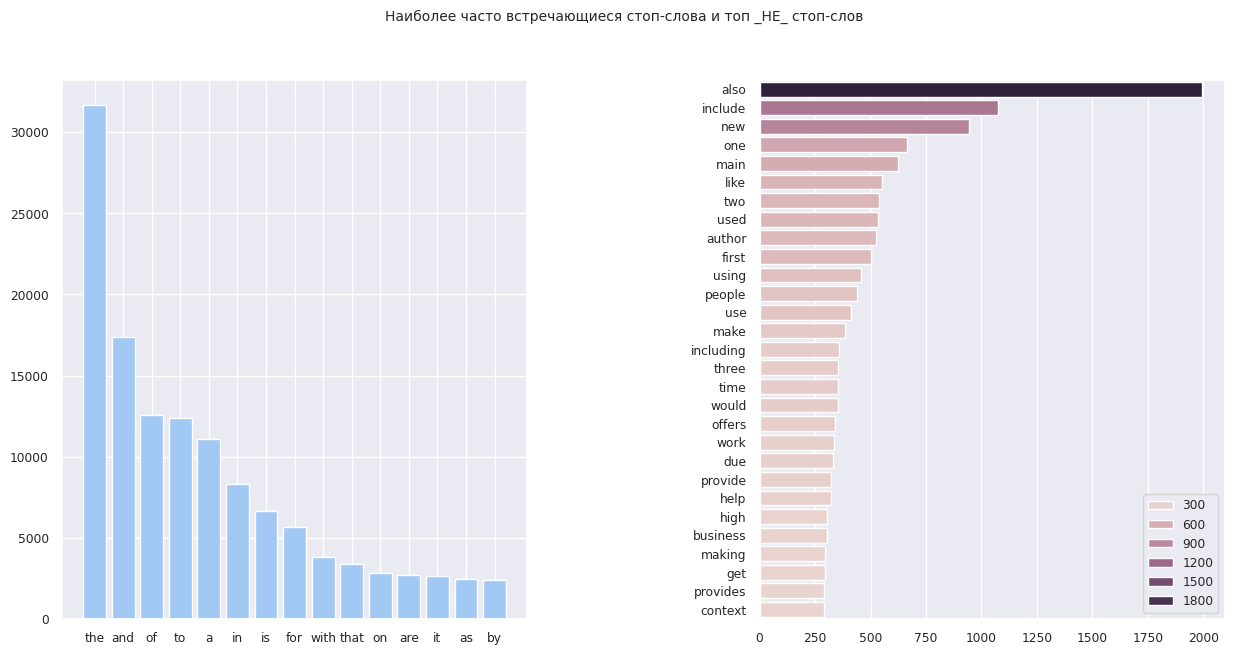

In [ ]:
plot_top_words(df['answer'])

answer:  
наиболее частотные стоп-слова - это артикль the, предлоги
наиболее частот НЕ стоп-слова - топ слов пересекается с колонкой context, например, one, new, main, like, можно предположить, что ответы связаны с контекстом, основаны на конксте

Посмотрим частотность по n-граммам

In [34]:
# функция для построения графиков частотности по n-граммам, для этого используем CountVectorizer (он выделит биграммы/триграммы)
def plot_top_ngrams(text, column, number, n=2):

    corp = corpus(text)

    def _get_top_ngram(corpus, n=None):
        # для извлечения  n-грамм используется CountVectorizer
        vec = CountVectorizer(ngram_range=(n, n), lowercase=True).fit(corpus)
        bag_of_words = vec.transform(corp)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word.lower(), sum_words[0, idx])
                      for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y = map(list,zip(*top_n_bigrams))
    plt.subplot(1, 3, number)
    sns.barplot(x=y,y=x, hue = y).set_title(f"{column} - {n}-граммы")

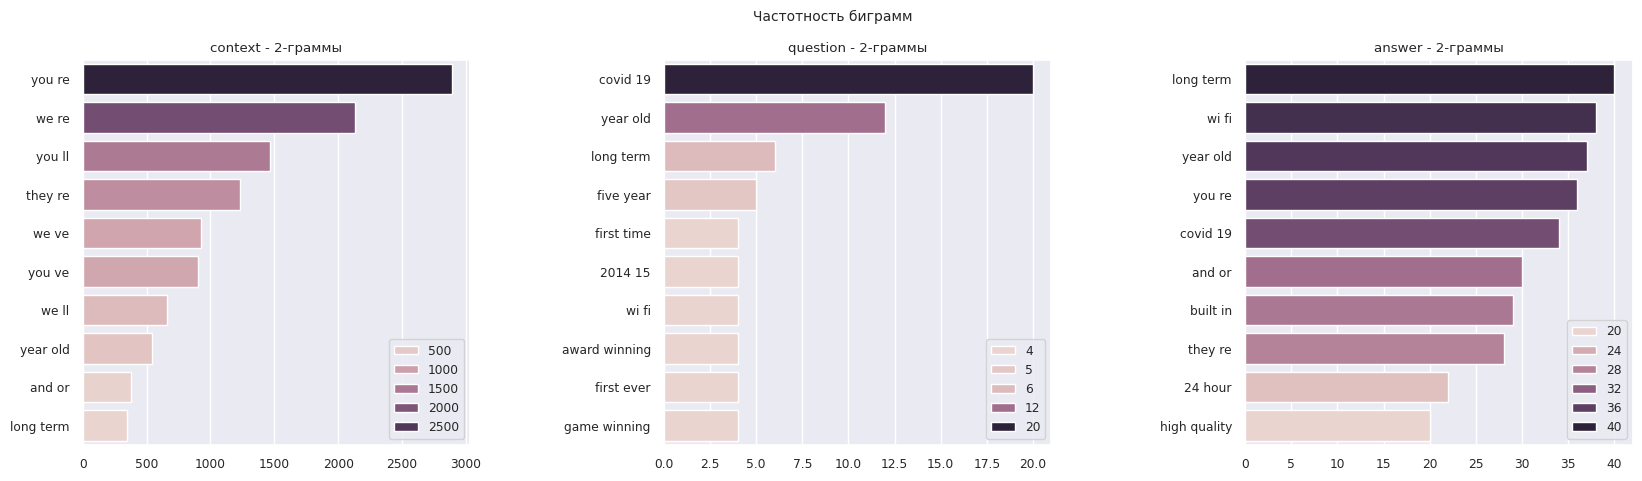

In [36]:
plt.figure(figsize = (20, 5)).suptitle('Частотность биграмм', fontsize=10)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plot_top_ngrams(df['context'], 'context', 1, 2)
plot_top_ngrams(df['question'], 'question', 2, 2)
plot_top_ngrams(df['answer'], 'answer', 3, 2)

* Для контекста сочетания из дву слов в большинстве случаев это службные связки, свойственные для английского языка, а также указание на возраст (year old)
* Для вопросов словосочетания - первое место covid 19 (его актуальность не удивляет), указание на время, долгосрочность, победителей в играх, конкурсах
* ответы коррелируют с вопросами по набору словосочетаний: также временные значения, возраст, ковид, появилось сочетание высокое качество, которое не вошло в топ ни в вопросах, ни в ответах, возможно связано с запросом о победах


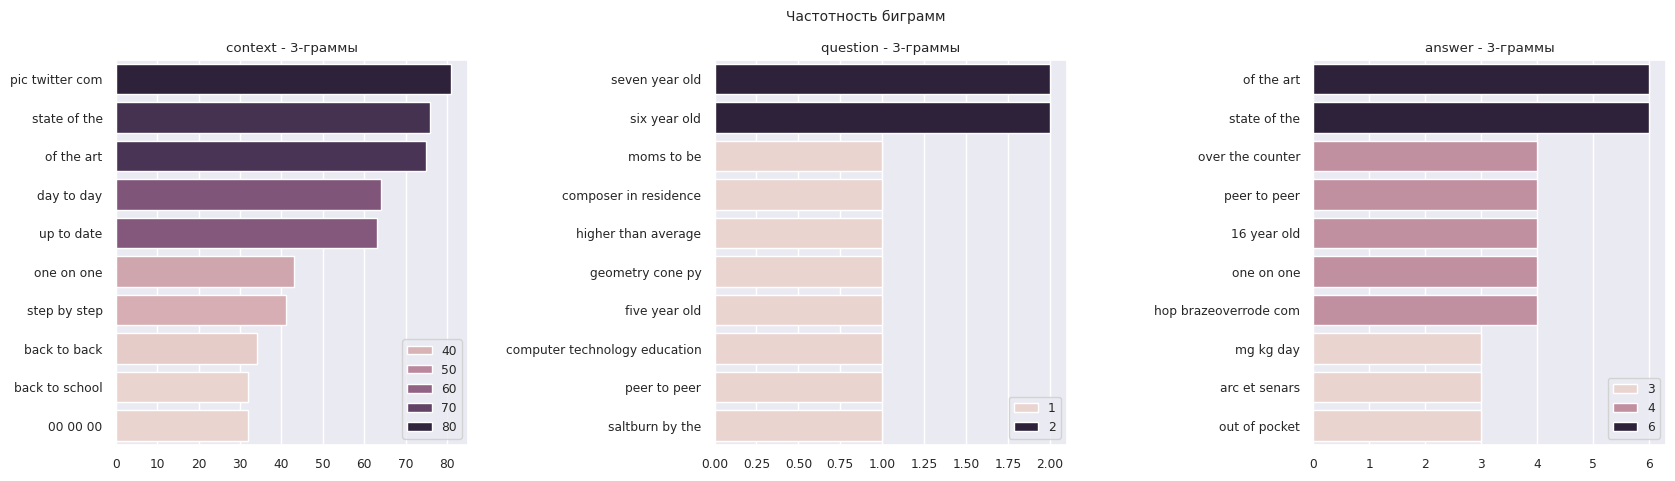

In [38]:
plt.figure(figsize = (20, 5)).suptitle('Частотность биграмм', fontsize=10)
plt.subplots_adjust(wspace=0.7, hspace=0.5)
plot_top_ngrams(df['context'], 'context', 1, 3)
plot_top_ngrams(df['question'], 'question', 2, 3)
plot_top_ngrams(df['answer'], 'answer', 3, 3)

* Для контекста на первом месте сочетание, связанное с соцсетью твиттер, значит в повествовании есть отсылки к материалам в твиттер. Далее идет состояние, искусство, такие вспомогательные сочетания, как "день ото дня", "один на один", "шаг за шагом", своственные повествованию, всплывает тема школы
* Для вопросов опять таки в топе возраст, далее упоминуются "будущие мамы", компьютерное техническое образование, уровень выше среднего
* В ответах есть упоминание искусства, состояния, возраста, ответы больше перекликаются с контекстом

Промежуточный вывод: колонки связные, то есть видно что контекст, вопросы и ответы имеют общее основание, так как наборы слов и сочетаний между собой коррелируют.

#### WORDCLOUD

In [42]:
# функция создает лемматизированный корпус слов

def preprocess(text, stop = STOPWORDS):
    corpus=[]
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for sent in tqdm(text):
        words=[w.lower() for w in word_tokenize(sent) if (w not in stop)]
        # лемматизированное слово (слово в нормальной форме)
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus

# набор функций для усиленного препроцессинга текста, чтобы в облаке слов не было предлогов, артиклей, цифр и других шумов

# оставляем только слова
def words_only(text):
    return " ".join(re.compile("[A-Za-z]+").findall(text))

# удаление слов меньше 2-х букв
def remove_word(text):
    return " ".join([token for token in text.split() if len(token) > 3])

# удаление стоп слов
def remove_stopwords(text, mystopwords = STOPWORDS):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
# приведение к нормальной форме
def lemmatize(text):
    lemmatizer = nltk.WordNetLemmatizer()
    try:
        return  " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    except:
        return " "

# применение всех препроцессоров
def prep(text):
    return remove_stopwords(lemmatize(remove_word(words_only(text.lower()))))

In [40]:
#копируем датасет, чтобы очистить колонки от "шума"
df_clear = df.copy()

In [47]:
df_clear['context']= df_clear.context.apply(lambda x: prep(x))
df_clear['answer']= df_clear.answer.apply(lambda x: prep(x))
df_clear['question']= df_clear.question.apply(lambda x: prep(x))
df_clear = df_clear.drop(columns = ['length__context_word',
       'length_contex_symbol', 'length__question_word',
       'length_question_symbol', 'length__answer_word',
       'length_answer_symbol'])

In [48]:
df_clear.head()

,context,question,answer
0,philip mummert assistant head mathematics depa...,philip mummert area research interest,philip mummert interested discrete dynamical s...
1,thing working better orgasm everyone want good...,thing work better orgasm home according sophie...,thing work better orgasm home include present ...
2,last three year firm perkins coie association ...,finding fourth annual survey conducted perkins...,finding survey include increasing adoption ind...
3,hell mendes hell italian vogue european fashio...,took photo mentioned context,photo taken steven meisel
4,greenhill lynchburg bath sqft edit zestimate h...,last sold price date property greenhill lynchburg,property greenhill lynchburg last sold april


In [49]:
def plot_wordcloud(text):

    corpus = text
    wordcloud = WordCloud(
        background_color='white',
        stopwords = STOPWORDS,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
    wordcloud=wordcloud.generate(str(corpus))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

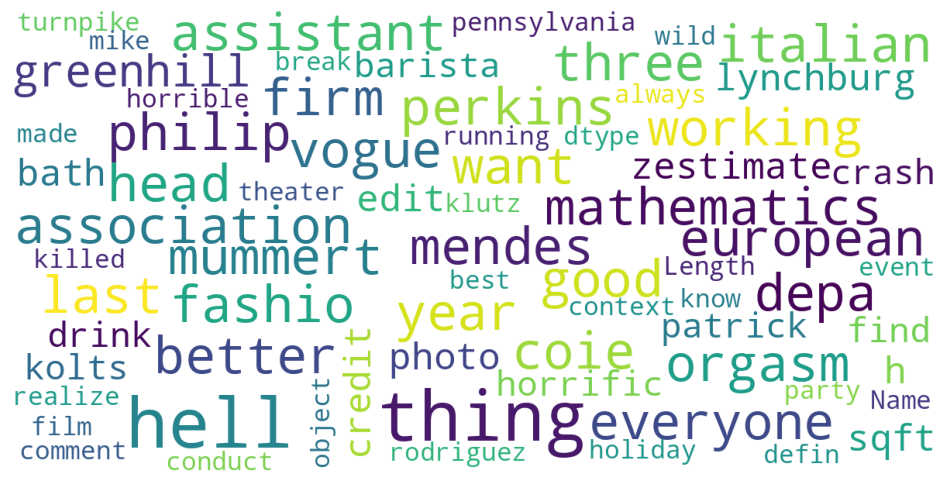

In [50]:
plot_wordcloud(df_clear['context'])

Привлекает внимание - мода, европейский, италия, ассистент, вещь, ад, ассоциация, фирма, пенсильвания, бариста, выходные

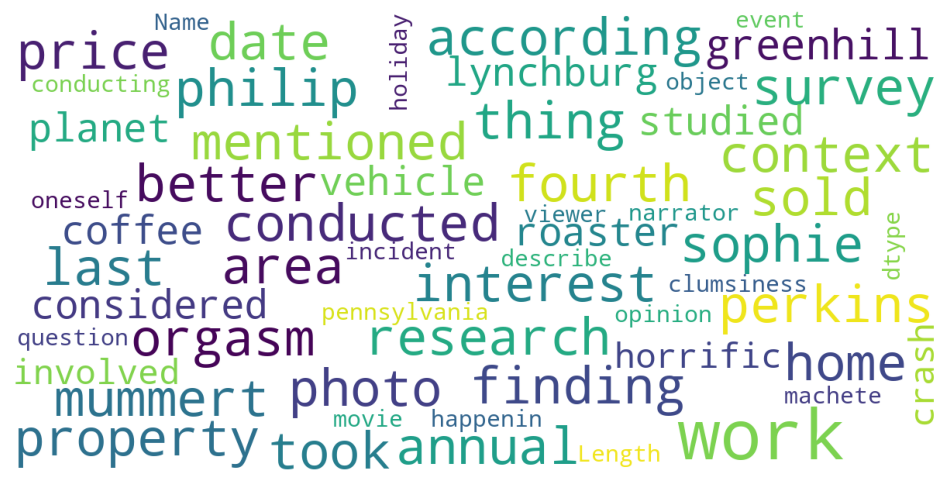

In [51]:
plot_wordcloud(df_clear['question'])

Привлекает внимание - территория, исслевование, продажа, дом, работа, свойства, кофе, даты выходные

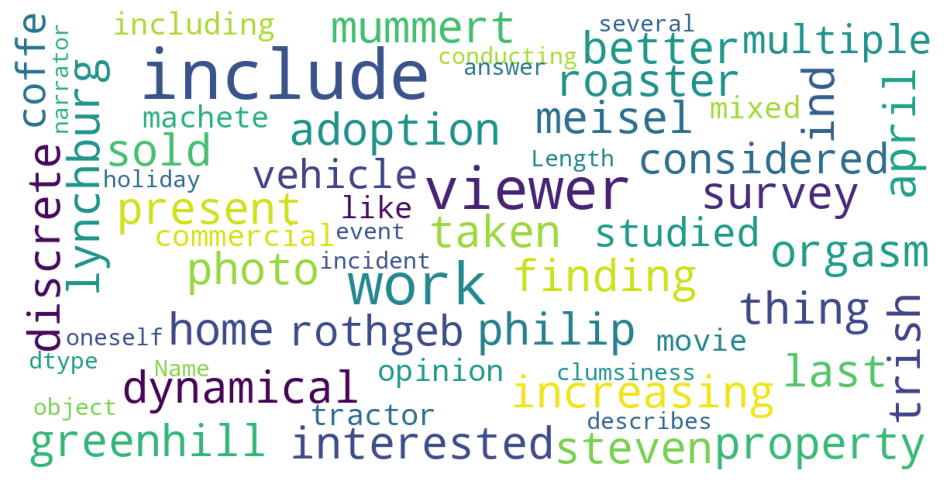

In [52]:
plot_wordcloud(df_clear['answer'])

Частотное слово include, возможно свойственно для построения ответа. упоминаются конкретные имена собственные, кофе, фото, продажи.

Диаграммы подтверждают гипотезу о связности текстов в колонках.

#### TSNE

 t-SNE — метод уменьшения размерности, в данном случае, мы используем его для визуализации расстояний между словами, плотности различных секций слов

In [55]:
# Препроцессинг текста и построение единого корпуса текста контекста для TNSE

def clear_text(text, mystopwords = STOPWORDS):
    #  разбиение на предложения
    sentences = []
    for text_i in tqdm(text):
        for el in sent_tokenize(text_i):
            sentences.append(el)

    return [prep(sentence).split() for sentence in tqdm(sentences)]


In [56]:
# применение функции к колонке контекст
text_lemm = clear_text(df.context, mystopwords = STOPWORDS)

100%|██████████| 361104/361104 [00:29<00:00, 12424.59it/s]


Создание векторов с помощью  Word2Vec для дальнейшей визуализации

In [57]:
# инициализация модели
%time  model_w2v = Word2Vec(text_lemm, workers=4, vector_size=300, min_count=5, window=10)

CPU times: user 1min 47s, sys: 459 ms, total: 1min 47s
Wall time: 1min 4s


In [58]:
model_w2v.build_vocab(text_lemm) # построение словаря
model_w2v.train(text_lemm, total_examples=model_w2v.corpus_count, epochs=model_w2v.epochs)
vocab_len = len(model_w2v.wv) # длина словаря
vocab_len

33805

In [59]:
# вывод близких слов
model_w2v.wv.most_similar(positive=["think"], topn=5)

[('gotten', 0.5447924733161926),
 ('thought', 0.5347248315811157),
 ('maybe', 0.525079607963562),
 ('worried', 0.5205362439155579),
 ('realize', 0.5154407620429993)]

In [ ]:
# проверка модели и словаря
print(model_w2v.wv.most_similar(positive=["bread", "cake"], negative=["sweet"], topn=1))
print(model_w2v.wv.most_similar("america", topn=3))
print(model_w2v.wv.doesnt_match("comedy thriller novel".split()))

[('soup', 0.7154677510261536)]
[('korea', 0.7231193780899048), ('african', 0.6452308893203735), ('american', 0.6430561542510986)]
novel


In [60]:
# для сбора частотности используем библиотеку  nltk.FreqDist
# иницализация
fd = FreqDist()

In [63]:
# подготовительные данные для tnse диаграммы
# определение частотности
top_words, top_only_words, top_words_count = [], [], []

# создание массива с 200 топ-слов
for text in text_lemm:
    fd.update(text)
for i in fd.most_common(200):
    # словарь с наиболее часто встречающимися словами (топ 200)
    top_words.append(i)
    top_words_count.append(i[1])
    # список топ-100 слов
    top_only_words.append(i[0])

In [64]:
# векторизация топ 200 слов
top_words_vec = model_w2v.wv[top_only_words]
# снижение размерности вектора слова
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

# https://docs.bokeh.org/en/latest/
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(title="T-SNE для топ-100", frame_height = 1000, frame_width = 1000)

source = ColumnDataSource(
    data=dict(
        x1=top_words_tsne[:,0],
        x2=top_words_tsne[:,1],
        names=top_only_words))

p.scatter(
    x="x1",
    y="x2",
    size=8,
    source=source)

labels = LabelSet(
    x="x1",
    y="x2",
    text="names",
    y_offset=6,
    text_font_size="8pt",
    text_color="#555555",
    source=source,
    text_align='right')

p.add_layout(labels)
show(p)

Альтернативный график с помощью  plotly.express

In [65]:
import plotly.express as px
fig = px.scatter(None, x=top_words_tsne[:,0], y=top_words_tsne[:,1],
labels={
"x": "x1",
"y": "x2",
},
opacity=1,
color=top_words,
hover_data=[top_only_words]
)

# Изменение цвета фона графика
fig.update_layout(dict(plot_bgcolor = 'white'))

# Обновление линий осей
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
showline=True, linewidth=1, linecolor='black')

# Установка названия рисунка
fig.update_layout(title_text="t-SNE для топ-100")

# Обновление размера маркера
fig.update_traces(marker=dict(size=10))

In [67]:
# 3-d график близости слов
from sklearn.manifold import TSNE

tsne_3d = TSNE(n_components = 3, random_state=0)
top_words_tsne_3d = tsne_3d.fit_transform(top_words_vec, )

fig = px.scatter_3d(
    top_words_tsne_3d, x=0, y=1, z=2,
    color = top_words, labels={'color': 'top_words'}
)
fig.update_traces(marker_size=8)
fig.show()

Выводы: по диаграммам не выявлено отдельных обособленных скоплений, в основном слова находятся на небольшом расстоянии, хорошо выявлены близкие по смыслу и синонимы. Видно что есть скопления, связанные с временными характеристиками, такими как год, минута, час, день  и т.д. что-то с образованием - школа, студенты, университет. С конкретными персонами, с продажами и ценами, местоположением - мир, америка, с публикациями - комментарии, отчеты, медиа и т.д.


####Topic modeling

Попробуем  более глубоко понять на какие темы тексты в колонке контекст

In [ ]:
# добавление нграмм

bigram_vectorizer = CountVectorizer(ngram_range=(2, 3),token_pattern=r'[A-Za-z]+', stop_words = STOPWORDS, min_df=10)
analyze = bigram_vectorizer.build_analyzer()
df['ngramm'] = df['context'].apply(lambda x: analyze(x))
df['ngramm'] = df['ngramm'].apply(lambda x: (', '.join(x)))

In [76]:
df.head(3)

,context,question,answer,length__context_word,length_contex_symbol,length__question_word,length_question_symbol,length__answer_word,length_answer_symbol,ngramm
0,Dr. Philip Mummert Assistant Head Mathematics ...,What is Dr. Philip Mummert's area of research ...,Dr. Philip Mummert is interested in discrete d...,223,1649,9,55,15,111,"[dr philip, philip mummert, mummert assistan..."
1,11 Things You Can Do While Working To Have A B...,What are some things you can do at work to hav...,Some things you can do at work to have a bette...,1104,6140,21,105,95,532,"[things working, working better, better orga..."
2,"For the last three years, law firm Perkins Coi...",What are some of the key findings from the Fou...,The key findings from the survey include incre...,990,6370,23,130,132,884,"[last three, three years, years law, law fi..."


In [83]:
!pip install pyLDAvis
clear_output()
import pyLDAvis.gensim # библиотека для визуализации LDA

In [84]:
# Функция, которая разбивает данные на топики (num_topics = 10) по темам с помощью модели gensim.models.LdaMulticore
def get_lda_objects(text):

    corpus = preprocess(text)
    dic = gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    lda_model =  gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 10,
                                   id2word = dic,
                                   passes = 10,
                                   workers = 2)

    return lda_model, bow_corpus, dic
# визуализация топиков,pyLDAvis - пакет извлекает информацию из подобранной тематической модели LDA для интерактивной веб-визуализации
def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic, mds='tsne')
    return vis

In [85]:
# построим анализ контекста по столбцу с n-граммам
lda_model, bow_corpus, dic = get_lda_objects(df['ngramm'])

100%|██████████| 11997/11997 [04:05<00:00, 48.96it/s]


In [86]:
lda_model.show_topics()

[(0,
  '0.005*"service" + 0.005*"use" + 0.005*"business" + 0.005*"need" + 0.004*"new" + 0.004*"time" + 0.004*"also" + 0.004*"one" + 0.004*"company" + 0.004*"data"'),
 (1,
  '0.009*"food" + 0.005*"make" + 0.005*"one" + 0.004*"water" + 0.004*"like" + 0.004*"skin" + 0.004*"also" + 0.004*"oil" + 0.003*"use" + 0.003*"time"'),
 (2,
  '0.010*"said" + 0.007*"school" + 0.007*"year" + 0.004*"police" + 0.004*"student" + 0.003*"time" + 0.003*"city" + 0.003*"day" + 0.003*"also" + 0.003*"one"'),
 (3,
  '0.006*"car" + 0.005*"price" + 0.004*"get" + 0.004*"one" + 0.004*"also" + 0.003*"use" + 0.003*"make" + 0.003*"new" + 0.003*"product" + 0.003*"used"'),
 (4,
  '0.009*"one" + 0.009*"like" + 0.007*"time" + 0.006*"get" + 0.006*"would" + 0.006*"love" + 0.006*"know" + 0.005*"thing" + 0.005*"people" + 0.005*"day"'),
 (5,
  '0.009*"year" + 0.005*"new" + 0.005*"market" + 0.005*"said" + 0.005*"one" + 0.004*"company" + 0.004*"also" + 0.004*"time" + 0.003*"price" + 0.003*"day"'),
 (6,
  '0.006*"new" + 0.005*"art"

In [87]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4      21.612572  15.337549       1        1  23.152564
0     -10.989284  15.555473       2        1  14.748564
9      -6.952993  31.007389       3        1  13.031833
7      11.214671  24.098679       4        1   8.726395
3       8.263987  12.728592       5        1   7.948386
8      21.408081  30.304552       6        1   7.181669
2      -0.109180  20.971600       7        1   6.718533
1      14.132668   2.361984       8        1   6.434802
6      -1.641206   5.136524       9        1   6.127576
5       6.308566  35.540928      10        1   5.929678, topic_info=       Term          Freq         Total Category  logprob  loglift
540    game  28308.000000  28308.000000  Default  30.0000  30.0000
344    said  48825.000000  48825.000000  Default  29.0000  29.0000
210    food  15788.000000  15788.000000  Default  28.0000  28.0000
719    year  72663.000000  72663.000000  Default  27.0000  27.0000
1483   team  22194.000000  22194.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
591     may   2314.587130  40101.182090  Topic10  -6.1896  -0.0270
420    well   2283.852878  40544.412372  Topic10  -6.2030  -0.0513
3791  group   2094.785100  18909.268765  Topic10  -6.2894   0.6250
412     two   2184.137835  36341.969014  Topic10  -6.2476   0.0134
266    like   2146.430817  66396.941872  Topic10  -6.2650  -0.6066

[1051 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
61794      7  0.990863   abdulla
41721     10  0.995012    abraaj
1552       1  0.120161     abuse
1552       2  0.018320     abuse
1552       3  0.776463     abuse
...      ...       ...       ...
719       10  0.143539      year
14062      1  0.990117     yeezy
17491      3  0.007756     zacks
17491     10  0.984958     zacks
51208      8  0.992275  zucchini

[5281 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 10, 8, 4, 9, 3, 2, 7, 6])

Площадь каждого круга представляет важность темы относительно корпуса  
Расстояние между центрами кругов указывает на сходство между темами
Гистограмма справа показывает 30 самых релевантных теме слов, по-другому их можно назвать ключевые слова. С помощью регулирования параметра лямбда можно изменять метрику релевантности. Темы не пересекаются и находятся на расстоянии между собой, что говорит о том, что можно выделить и большее количество тем, чем 10.

Тема 1 -  наиболее релевантными словами являются: one, like, love, people, book (условно говоря тема о предпочтениях людей).

Тема 2 - сервис, бизнес, работа, продукт, софт

Тема 3 - здоровье, закон, правильство, сервис, забота

Тема 4 - игры, команды, сезон, игроки

Тема 5 - машины, дизайн, модели

Тема 6 - отели, номера, свадьбы, казино

Тема 7 - школа, университет, семья, церковь

Тема 8 - еда, зелень, курица, яйца, блюда, рецепты

Тема 9 - музей, искусство, комьюнити, история, премия

Тема 10 - фильмы, музыка, forex, инвесторы, трейдинг, магазины


Самые многочисленные топики - 1, 2, 3 темы

In [91]:
# построим анализ контекста по столбцу с context очищенному от "шума"
lda_model, bow_corpus, dic = get_lda_objects(df_clear['context'])

100%|██████████| 11997/11997 [00:37<00:00, 323.16it/s]


In [92]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
5      -6.392532  -4.338628       1        1  24.918428
4     -21.835052  -9.011027       2        1  17.597724
0      22.378962   6.971775       3        1  10.945821
9       6.907196   3.729749       4        1  10.890454
2     -23.065361   9.440947       5        1   7.727828
3      -3.797283 -20.215778       6        1   6.773610
1       8.499827  21.446898       7        1   6.730222
6      -6.731661  11.252237       8        1   5.085099
8      12.920859 -11.827659       9        1   4.985780
7     -10.510740  26.647472      10        1   4.345035, topic_info=         Term         Freq         Total Category  logprob  loglift
507      game  5801.000000   5801.000000  Default  30.0000  30.0000
3217  student  3247.000000   3247.000000  Default  29.0000  29.0000
79     school  4209.000000   4209.000000  Default  28.0000  28.0000
753     hotel  2003.000000   2003.000000  Default  27.0000  27.0000
320      said  9599.000000   9599.000000  Default  26.0000  26.0000
...       ...          ...           ...      ...      ...      ...
265    minute   464.594004   2302.178881  Topic10  -5.7846   1.5357
599   product   521.121389   4260.527942  Topic10  -5.6698   1.0350
257      make   551.113256  10571.561504  Topic10  -5.6138   0.1822
2762    water   391.543004   2980.646432  Topic10  -5.9557   1.1063
1206   online   367.941045   3354.489328  Topic10  -6.0179   0.9260

[931 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
75596      8  0.978303    abarth
4193       1  0.008591  academic
4193       2  0.143902  academic
4193       3  0.012887  academic
4193       4  0.090207  academic
...      ...       ...       ...
2061       9  0.026477      york
2061      10  0.007447      york
77219      5  0.967608      yule
48469     10  0.966536  zucchini
38553     10  0.986874      zuma

[4426 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 1, 10, 3, 4, 2, 7, 9, 8])

По большей части темы получились похожие, что позволяет уже сделать выводы о чем наш основной столбец с контекстами, это:

1. тексты о спорте,
2. компьютерных играх,
3. отдыхе в отелях (пляж/виды) + семейных мероприятиях/праздниках,
4. об образовании,
5. об искусстве (музеях, кинематографе),
6. о здоровье и зравоохранении
7. рецепты/еда
8. компьютерная индустрия
9. компании, бизнес
10. торговля, магазины, покупки, электронная торговля

In [93]:
# построим анализ контекста по столбцу с question
lda_model, bow_corpus, dic = get_lda_objects(df_clear['question'])
plot_lda_vis(lda_model, bow_corpus, dic)

100%|██████████| 11997/11997 [00:01<00:00, 6717.50it/s]


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
9      17.052544 -44.743980       1        1  13.989086
3      44.994991 -10.482922       2        1  11.248588
6      18.051620  18.247147       3        1   9.889105
4      49.021881  38.376808       4        1   9.572512
8     -52.411606   3.040498       5        1   9.540361
7     -39.321259  50.893993       6        1   9.533633
1       5.384335  57.117290       7        1   9.468333
0     -18.307087  20.131212       8        1   9.385832
2      -1.693536 -12.328883       9        1   8.932054
5     -31.994791 -34.927834      10        1   8.440496, topic_info=          Term        Freq       Total Category  logprob  loglift
23     context  877.000000  877.000000  Default  30.0000  30.0000
24   mentioned  415.000000  415.000000  Default  29.0000  29.0000
5    according  781.000000  781.000000  Default  28.0000  28.0000
190     reason  121.000000  121.000000  Default  27.0000  27.0000
638    amenity   88.000000   88.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
924       goal   16.920562  106.518282  Topic10  -5.9301   0.6323
5    according   20.801861  781.955157  Topic10  -5.7236  -1.1546
220      focus   15.836710   88.479687  Topic10  -5.9963   0.7517
241       game   16.073722  190.377382  Topic10  -5.9814   0.0003
445       year   15.840114  185.781479  Topic10  -5.9961   0.0101

[761 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5         1  0.090798  according
5         2  0.384933  according
5         3  0.195663  according
5         4  0.072894  according
5         5  0.011510  according
...     ...       ...        ...
405       8  0.534876       york
405       9  0.066859       york
2706      3  0.185058      youth
2706      9  0.061686      youth
2706     10  0.678545      youth

[1946 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 7, 5, 9, 8, 2, 1, 3, 6])

По темам вопросов видим, что ключевыми словами самой многочисленной темы является:

авторы/книги/школы/ингридиенты/компании/цели/год(как дата/веб-сайты/города

персонажи/игры/выгода/предложение/награда

игроки/спорт/счет

упоминаются соцсети/города

есть храктерные для вопросов слова, такие как согласно/цели/роли/названия

В целом можно сделать вывод, что вопросы довольно связаны с темами контекста

In [94]:
# построим анализ контекста по столбцу с answer
lda_model, bow_corpus, dic = get_lda_objects(df_clear['answer'])
plot_lda_vis(lda_model, bow_corpus, dic)

100%|██████████| 11997/11997 [00:09<00:00, 1314.17it/s]


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3       44.972008  189.551910       1        1  25.586436
6      148.192810  -65.021996       2        1  12.828252
4      145.486877   71.044617       3        1  11.302898
5       21.356899 -156.321167       4        1  10.376829
8       32.945538  -38.721138       5        1   9.461383
1       24.065596   75.247078       6        1   7.710259
7     -185.109909   27.530491       7        1   6.384868
0      -70.357178   10.800361       8        1   6.339939
9      -92.166603  140.793915       9        1   5.809535
2     -105.819183 -105.761383      10        1   4.199601, topic_info=          Term        Freq        Total Category  logprob  loglift
422    service  721.000000   721.000000  Default  30.0000  30.0000
681       year  614.000000   614.000000  Default  29.0000  29.0000
772       room  273.000000   273.000000  Default  28.0000  28.0000
152     author  578.000000   578.000000  Default  27.0000  27.0000
279      offer  490.000000   490.000000  Default  26.0000  26.0000
...        ...         ...          ...      ...      ...      ...
417      event   15.726115   297.126845  Topic10  -6.5128   0.2313
56        also   16.379433  1862.657063  Topic10  -6.4721  -1.5636
1077  favorite   12.849639    58.201209  Topic10  -6.7148   1.6596
2009    series   12.993948   134.258540  Topic10  -6.7037   0.8349
787       type   13.026984   221.597136  Topic10  -6.7011   0.3363

[817 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
967        1  0.250079  according
967        2  0.085133  according
967        3  0.015962  according
967        4  0.234116  according
967        5  0.037246  according
...      ...       ...        ...
3948       7  0.694672      youth
3948       9  0.173668      youth
1172       1  0.965979    youtube
1173       8  0.873186     zillow
10753      7  0.934179     zombie

[2728 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 5, 6, 9, 2, 8, 1, 10, 3])

По ответам выделены темы, содержащие ключевые слова

сервисы/информация/пользователи/данные/студенты/бизнес/работа/цели/саппорт/дизайн/видео

дома/цена/уровень/риски/качество/количество/рейтинг/магазины

еда/перец/сахар/курица и т.д. связанное с рецептами

женщины/вечеринки/рестораны/кухня/гости

города/национальности/население
и т.д.

При более внимательном рассмотрении не было обнаружено тем, которые не освещены в контексте. Можно утвердиться в предположении о связности текстов.

#### Parts of speech tagging

Анализ на части речи, использование их в текстах, распределение, топ частей речи в текстах. Для выявления частей речи используем nltk модель averaged_perceptron_tagger (модель обучена на основе персептрона). Анализ проводим по очищенному нормализованному тексту без пунктуации и посторонних символов.


* Noun (NN) - Существительное
* NNS - существительное в множественном числе
* Verb (VB) - Глагол
* Adjective (JJ) - Прилагательное
* Adverb  (RB) - Наречие
* Preposition (IN)- Предлог
* Conjunction (CC) - Союз
* Pronoun (PRP) - Местоимение
* Interjection (INT)  - Междометие
* NNP означает существительное собственное
* DT - артикли
* CD - дата

In [95]:
nltk.download('averaged_perceptron_tagger')
sns.set_palette('pastel')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [98]:
# функция выделяет части речи
def pos(text):
        pos = nltk.pos_tag(word_tokenize(text))
        pos = list(map(list,zip(*pos)))[1]
        return pos

def filter_pos(text, part_of_speach='NN'):
    # функция вподсчитывает часть речи
        pos_type = []
        pos = nltk.pos_tag(word_tokenize(text))
        for word,tag in pos:
            if tag == part_of_speach:
                pos_type.append(word)
        return pos_type

def plot_pos(text, part_of_speach='NN'):

    plt.figure(figsize = (15, 7)).suptitle('Наиболее часто встречающиеся части речи', fontsize=10)
    tags = tqdm(text.apply(lambda x : pos(x)))
    tags = [x for l in tqdm(tags) for x in l]
    counter = Counter(tags)
    x,y =list(map(list,zip(*counter.most_common(10))))
    plt.subplot(1, 2, 1)
    sns.barplot(x = y,y = x).set_title('Распределение по частям речи')

    words=text.apply(lambda x : filter_pos(x))
    words=[x for l in words for x in l]
    counter=Counter(words)
    x,y=list(map(list,zip(*counter.most_common(7))))
    plt.subplot(1, 2, 2)
    sns.barplot(x = y,y = x, hue = y).set_title(part_of_speach)


100%|██████████| 11997/11997 [00:00<00:00, 50176.71it/s]


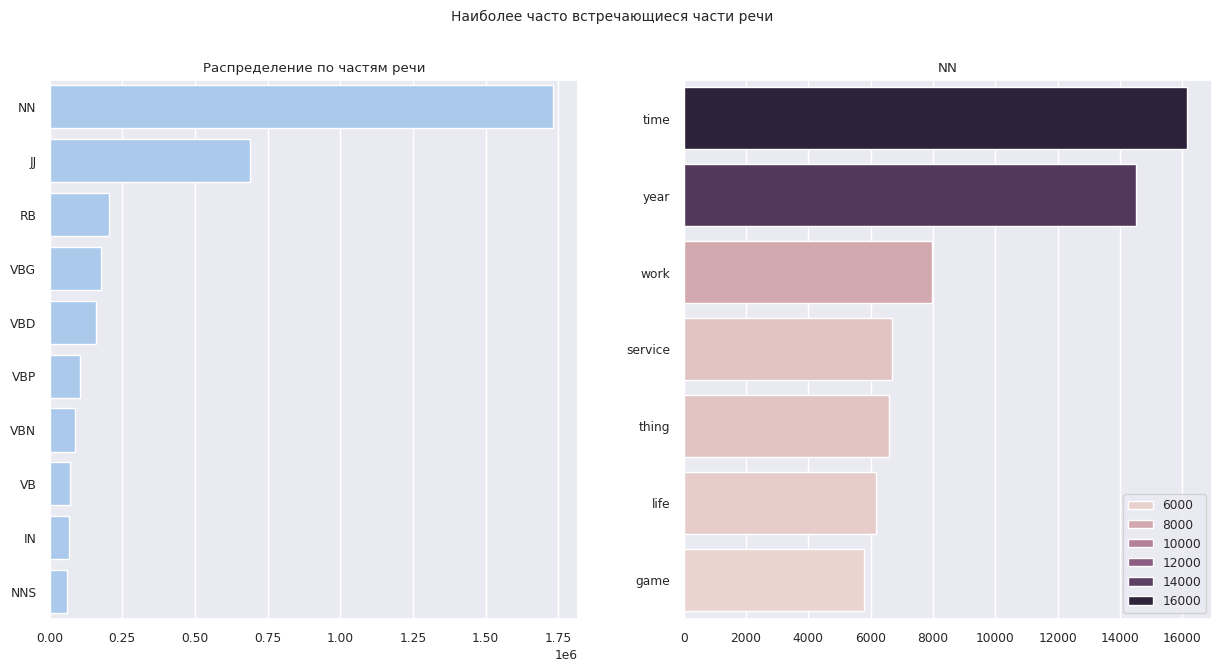

In [99]:
plot_pos(df_clear['context'])

Ожидаемо в тексте большинство существительных, в контексте - это слова, связанные с датой, работой, играми, вещами, жизнью

100%|██████████| 11997/11997 [00:00<00:00, 318945.44it/s]


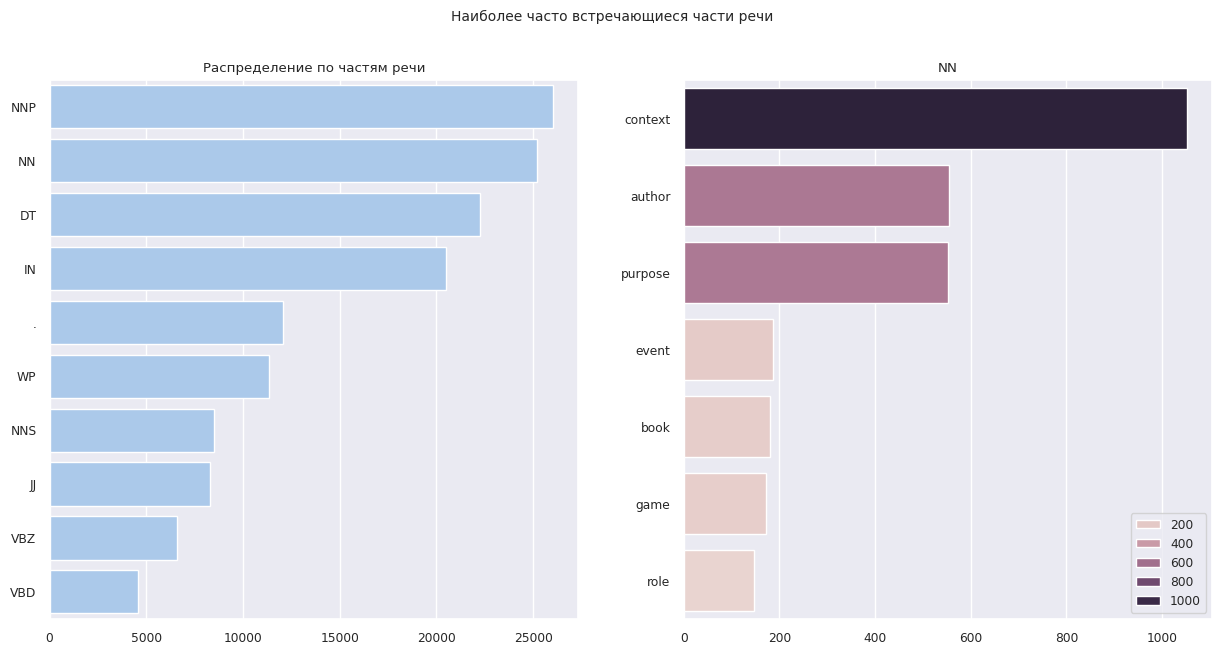

In [100]:
plot_pos(df['question'])

В вопросах, часто упоминается само слово context, может означать корпус текста, к которому обращен вопрос, автор, цели, события, книги, игры, роли

100%|██████████| 11997/11997 [00:00<00:00, 351042.02it/s]


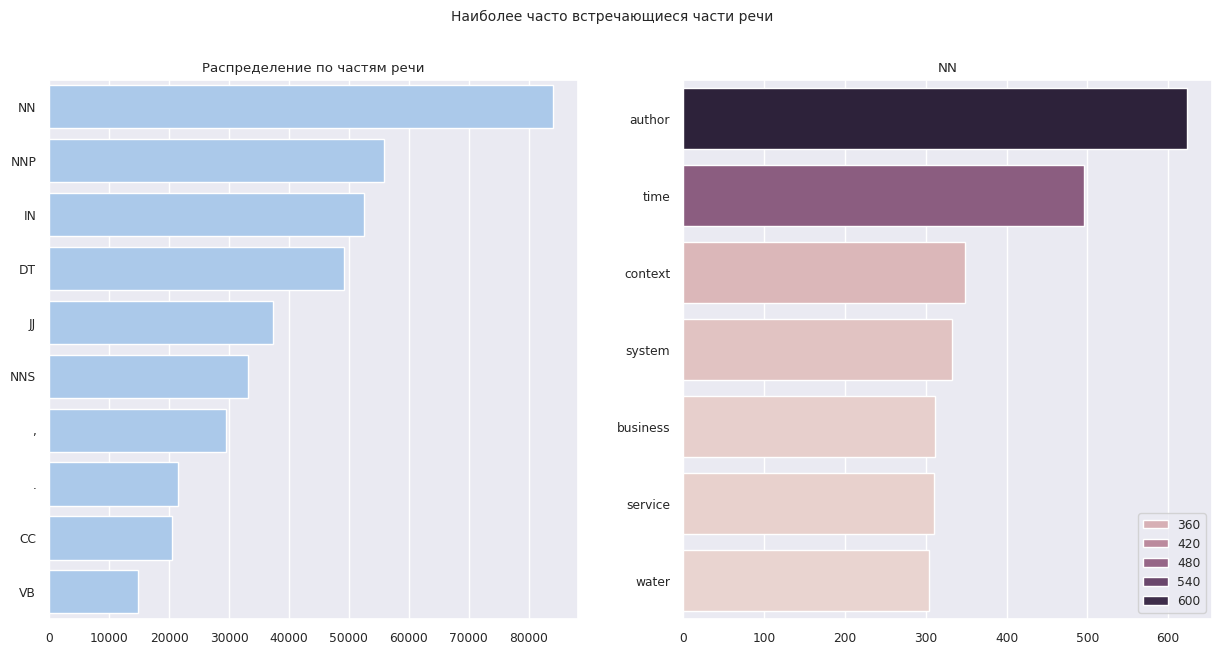

In [101]:
plot_pos(df['answer'])

Большинство ответов базируется на существительных автор, время, опять же контекст, система, бизнес, сервис, вода

#### Named entity recognition

Для извлечени именованных сущностей используется библиотека spacy, модель en_core_web_sm (English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer / written text (blogs, news, comments)) - модель обучена на английском языке на письменном веб-тексте (блоги, новости, комментарии), включает в себя слова, синтаксис и сущности.
[Модели](https://spacy.io/models/en)

* PERSON - People, including fictional.
* NORP - Nationalities or religious or political groups.
* FAC - Buildings, airports, highways, bridges, etc.
* ORG - Companies, agencies, institutions, etc.
* GPE - Countries, cities, states.
* LOC - Non-GPE locations, mountain ranges, bodies of water.
* PRODUCT - Objects, vehicles, foods, etc. (Not services.)
* EVENT - Named hurricanes, battles, wars, sports events, etc.
* WORK_OF_ART - Titles of books, songs, etc.
* LAW - Named documents made into laws.
* LANGUAGE - Any named language.
* DATE - Absolute or relative dates or periods.
TIME - Times smaller than a day.
* PERCENT - Percentage, including "⅒".
* MONEY - Monetary values, including unit.
* QUANTITY - Measurements, as of weight or distance.
* ORDINAL - "first", "second", etc.
* CARDINAL - Numerals that do not fall under another type.

In [18]:
import spacy
nlp = spacy.load("en_core_web_sm")


def get_ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

def get_ner_person(text,ent):
    doc = nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

def plot_named_entity(text, entity="PERSON"):

    plt.figure(figsize = (15, 7)).suptitle('Наиболее часто встречающиеся сущности', fontsize=10)


    ent=text.apply(lambda x : get_ner(x))
    ent=[x for sub in ent for x in sub]
    counter=Counter(ent)
    count=counter.most_common()

    x,y=map(list,zip(*count))
    plt.subplot(1, 2, 1)

    sns.barplot(x=y,y=x).set_title('Распределение по именованным сущностям')


    entity_filtered=text.apply(lambda x: get_ner_person(x,entity))
    entity_filtered=[i for x in entity_filtered for i in x]

    counter=Counter(entity_filtered)
    x,y=map(list,zip(*counter.most_common(10)))
    plt.subplot(1, 2, 2)
    sns.barplot(x = y,y = x, hue = y).set_title(entity)

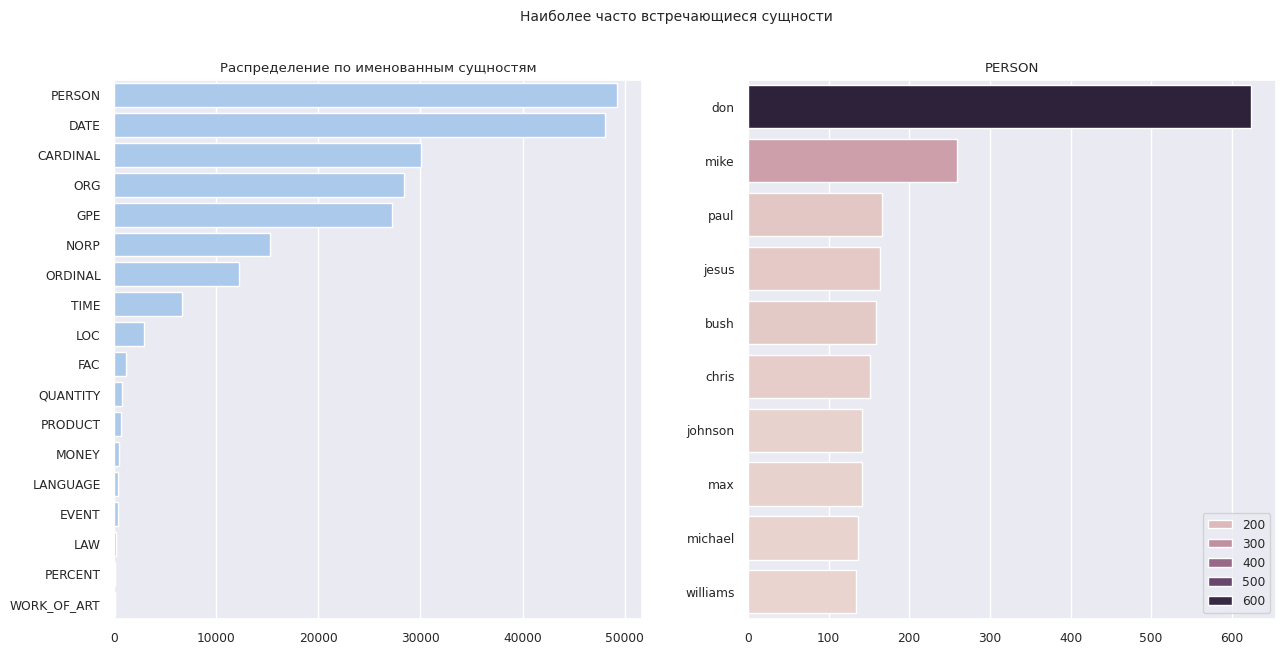

In [20]:
plot_named_entity(df_clear['context'])

Эти графики также дают нам предстваление о сути имеющихся текстов, видно, что в текстах речь о персонах/людях, о датах, числительных, организациях, локациях, национальностях, политических группах,  времени, о водоемах, ландшафте.
При рассмотрении топовой категории - персоны: видим, что речь идет о конкретных именах.

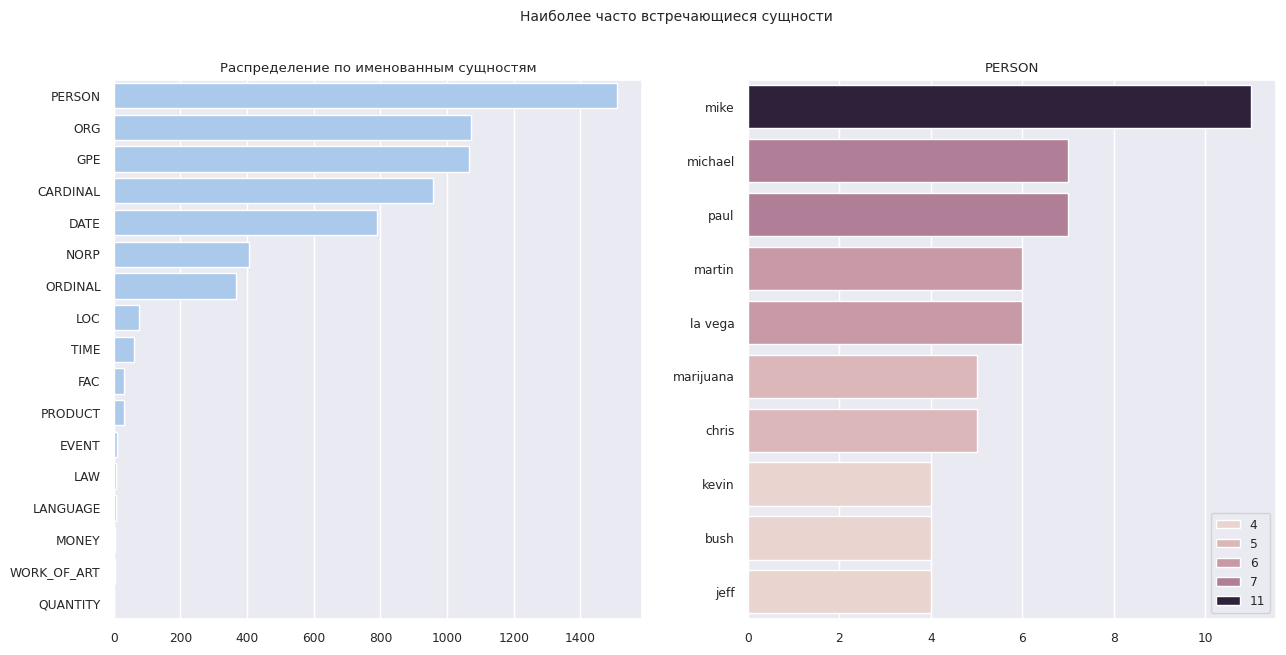

In [21]:
plot_named_entity(df_clear['question'])

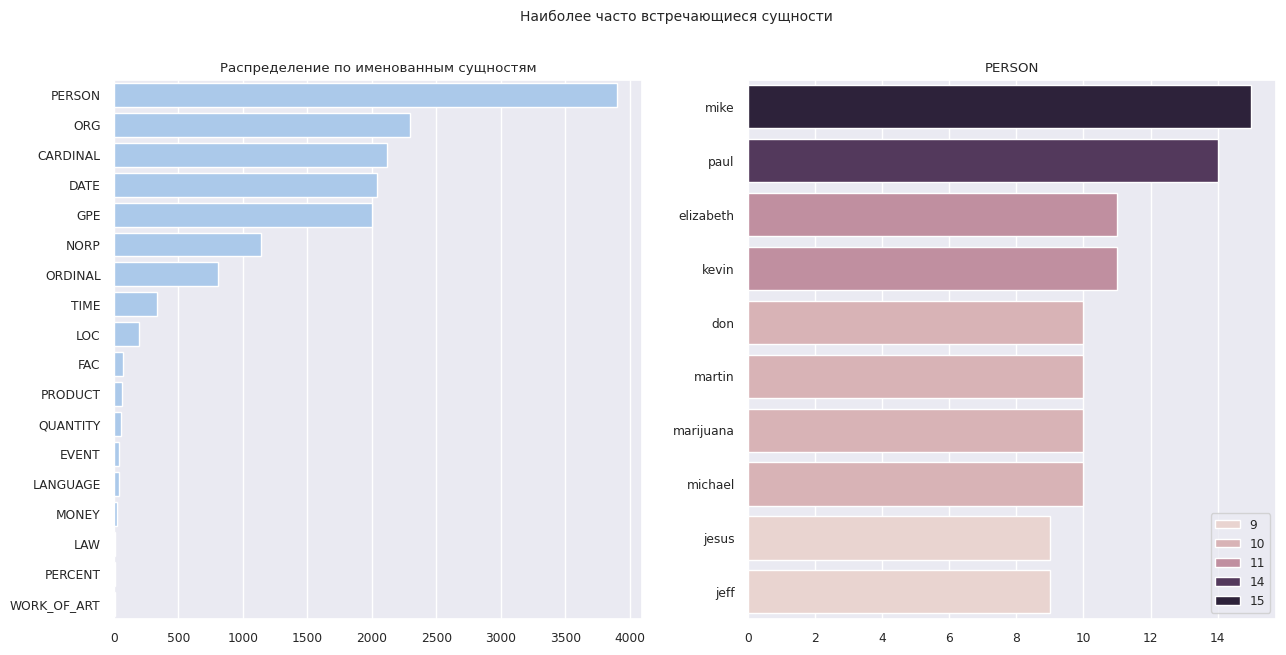

In [19]:
plot_named_entity(df_clear['answer'])

Графики по колонкам с вопросами и ответами показывают аналогичное распределение.

**Выводы:**

Данные в датасете консистентны, то есть прослеживается связь вопрос - контекст - ответ.

Данные о жизни, о насущных проблематиках жизни:  
отдых/путешествия/времяпрепровождение  
образование  
книги/фильмы  
рецепты  
события в мире искусства  
премии награждения  
компьютерная индустрия и компьютерные игры  


Также видно, что вопросы какаются конкретных личностей, определенных мест или локаций, актуальных болезней. Данные подойдут для вопросно - ответной системы.




